## basical DQN



In [1]:
# Create and wrap the environment
import numpy as np
import torch
from atari_wrappers import make_atari, wrap_deepmind,LazyFrames
env = make_atari('PongNoFrameskip-v4') # only use in no frameskip environment
env = wrap_deepmind(env, scale = False, frame_stack=True )
n_actions = env.action_space.n
state_dim = env.observation_space.shape
obs = env.reset()
obs = np.array(obs).reshape(4,84,84)
# obs = torch.from_numpy(obs).transpose(0,2) # [84,84,4]=>[4,84,84]
print(obs.shape, n_actions, state_dim)

(4, 84, 84) 6 (84, 84, 4)


In [2]:
# preprocess image
from PIL import Image
import matplotlib.pyplot as plt

def prepro_(obs,image_size=[80,80]):
    """
    Call this function to preprocess RGB image to grayscale image if necessary
    This preprocessing code is from
        https://github.com/hiwonjoon/tf-a3c-gpu/blob/master/async_agent.py
    
    Input: 
    RGB image: np.array
        RGB screen of game, shape: (210, 160, 3)
    Default return: np.array 
        Grayscale image, shape: (1, 80, 80) 
    """
    y = obs.astype(np.uint8)
    y_gray = np.dot(y[...,:3],[0.2126,0.7152,0.0722])  # rgb2gray
    resized = np.array(Image.fromarray(y_gray).resize((image_size[0],image_size[1])))
    return np.expand_dims(resized.astype(np.float32), axis=0)  # [1,80,80]

# preprocess
def prepro(obs):
    """
    preprocess observation 
    [84,84,4]=>[4,84,84]
    """
    obs = obs._force().transpose(2,0,1)/255  # 0-255 => 0-1, [84,84,4] => [4,84,84]
    return obs

In [3]:
# net
import torch
from torch import nn
class Net(nn.Module):
    """
    Initialize a deep Q-learning network as described in
    https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
    Arguments:
        in_channels: number of channel of input.
            i.e The number of most recent frames stacked together as describe in the paper
        out_num: number of action-value to output, one-to-one correspondence to action in game.
    """
    def __init__(self, in_channel=4, out_num=6):
        super(Net,self).__init__()
        # layer setting paramters
        layers = [32,64,64]
        # output_size = (input_size-kernel_size)/stride + 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel,layers[0],kernel_size=8,stride=4), # [batch,4,84,84]=>[batch,layers[0],20,20] 
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(layers[0],layers[1],kernel_size=4,stride=2), # [batch,layers[0],20,20]=>[batch,layers[1],9,9]
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(layers[1],layers[2],kernel_size=3,stride=1), # [batch,layers[1],9,9]=>[batch,layers[2],7,7]
            nn.ReLU(),
        )
        self.linear1 = nn.Sequential(
            nn.Linear(7*7*layers[2], 512),
            nn.ReLU()
        )
        self.linear2 = nn.Linear(512, out_num)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # flatten
        x = x.reshape(x.size(0), -1)  # [batch, layers[2],7,7]=>[batch,layers[2]*7*7]
        x = self.linear1(x)
        y = self.linear2(x)
        # y = F.softmax(y)  # turn to probability
        return y
pre_net = Net()
print(pre_net)

Net(
  (conv1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (linear1): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
  )
  (linear2): Linear(in_features=512, out_features=6, bias=True)
)


In [4]:
from torch import optim
import torch.nn.functional as F
# DQN
class DQN():
    def __init__(self, args, env, load_model=False):
        
        # use cuda
        cuda = True
        if cuda:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device('cpu')
        # env
        self.env = env
        self.n_actions = env.action_space.n
        self.dim_shape = env.observation_space.shape
        
        # build model
        self.eval_model = Net()  # model for update
        self.tar_model  = Net()  # model for predict next Q    
        self.eval_model, self.tar_model = self.eval_model.to(self.device), self.tar_model.to(self.device)
        # load model
#         load_model = load_model        
        if load_model:
            self.eval_model.load_state_dict(torch.load('dqn.mdl'))
            print('have load model from dqn.mdl')
        # copy params to tar
        self.tar_model.load_state_dict(self.eval_model.state_dict())  
        self.iter_max = args.iter_max # update tar_model per iter_max
        self.iter = 0
        
        # train params
        self.batchsz = args.batchsz
        self.lr = args.lr
        self.learning_start = 10000
        
        # optim
#         self.optimizer = optim.Adam(self.eval_model.parameters(), self.lr)
        self.optimizer = optim.RMSprop(self.eval_model.parameters(),lr=self.lr, eps=0.001, alpha=0.95)
#         self.cost_F = nn.MSELoss()
        
        # store record
        self.memory_sz = 100000
        self.memory_state = np.zeros((self.memory_sz,4,84,84))  # state, [batch, channel, 80, 80]
        self.memory_state_next = np.zeros((self.memory_sz,4,84,84))  # state_next, [batch, channel, 80, 80]
        self.memory_a_r_done = np.zeros((self.memory_sz, 3))  # a,r, [batch, 4], [obs_a, a, r, obs_b]
        self.memory_count = 0 # count the num of record
        
        # hyperparams
        self.decay = 0.99
        self.episodes = args.episodes
        self.log_interval = args.log_interval  # print state per log_interval epsisode
        self.save_interval = args.save_interval  # interval for save model
        
        self.epilon_max = 1
        self.epilon_min = 0.01
        self.learning_start = 10000  # 装满10000 再开始
        self.epilon_decay = 30000
    
    def store_record(self, state, a, r, state_next, done):
        # store done for check the last observation
        idx = self.memory_count % self.memory_sz
        self.memory_state[idx,:] = state
        self.memory_state_next[idx,:] = state_next
        a_r_done = np.hstack((a, r, done))
        self.memory_a_r_done[idx,:] = a_r_done
        self.memory_count += 1
        
    def get_record_batch(self, batchsz):
        # get a batch of records
        memory_count = self.memory_sz if self.memory_count>self.memory_sz else self.memory_count
        batch_idx = np.random.choice(memory_count, batchsz, replace=False) # return no same idx
        batch_state = self.memory_state[batch_idx,:]
        batch_state_next = self.memory_state_next[batch_idx,:]
        batch_act = self.memory_a_r_done[batch_idx,0]
        batch_r   = self.memory_a_r_done[batch_idx,1]
        batch_done = self.memory_a_r_done[batch_idx, 2]
        
        # np.array to torch.tensor
        device = self.device
        state, state_next = torch.from_numpy(batch_state).to(device), torch.from_numpy(batch_state_next).to(device)
        act_s, r_s = torch.from_numpy(batch_act).to(device), torch.from_numpy(batch_r).to(device)
        done_s = torch.from_numpy(batch_done).to(device)
        
        return state, act_s, r_s, done_s, state_next
    
    def learn(self):
        # learn the model
        
        # get data
        state, act_s, r_s, done_s, state_next = self.get_record_batch(self.batchsz)
        
        # pre
        eval_q = self.eval_model(state.float()).gather(1,act_s.unsqueeze(1).long())  # get pre and choose Q with act_c
        eval_q = eval_q.squeeze(-1) # [batch, 1] = [batch]
        # compute label
        next_q = self.tar_model(state_next.float()).detach() # not update so use detach
        next_max_q = next_q.max(1)[0] # torch.max() return [max_data, max_idx]
        decay = torch.tensor(self.decay).float().to(self.device)
        tar_q = r_s.float() + decay*next_max_q
        tar_q = torch.where(done_s>0, r_s.float(), tar_q)  # Q_next = r when done is true
        
        #print(eval_q, tar_q)
#         loss = self.cost_F(eval_q, tar_q) # loss expect input dim=[batch,1]
        loss = F.smooth_l1_loss(eval_q, tar_q)
    
        self.optimizer.zero_grad()
        loss.backward()
        # clip gradient
        for param in self.eval_model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        # update tar_model
        self.iter += 1
        if self.iter%self.iter_max==0:
            self.tar_model.load_state_dict(self.eval_model.state_dict())
        
        return loss.cpu().item() # ruturn mean loss
    
    def train(self):
        episodes = self.episodes
        losses = []
        rewards  = []
        
        # decay function explot ratio
        epilon_by_g_step = lambda step_idx:self.epilon_min + (self.epilon_max-self.epilon_min)*np.exp(-1*step_idx/self.epilon_decay)
        # global step
        global_step = 0
        
        for epis in range(episodes):
            obs_bef = self.env.reset()
            state = prepro(obs_bef) # [84,84,4]=>[4,84,84]
            reward_sum = 0
            loss_ = []
            
            while True:
                # decay explot ratio
                epsilon = epilon_by_g_step(global_step)
                global_step += 1 
                act = self.make_action(state, epsilon=epsilon) # choose action
                obs_aft, r, done, inf = self.env.step(act)
                state_next = prepro(obs_aft)
                reward_sum += r
                
                # store data
                self.store_record(state, act, r, state_next, done)
                
                if done:                    
                    rewards.append(reward_sum)
                    losses.append(np.mean(loss_))
                    break  # start another episode
                else:
                    state = state_next
            
                # learn model
                if self.memory_count == self.learning_start:
                    print('#'*30 + 'start learning' + '#'*30)
                if self.memory_count > self.learning_start:
                    loss = self.learn()
                    loss_.append(loss)
                
            # print train state
            if epis%self.log_interval==0 and epis>0:
                #print(losses)
                print('global step:{}'.format(global_step-1),
                      'episode :{}/{}'.format(epis, self.episodes), 
                      'aver loss:{:.5f}'.format(np.mean(losses[-10:])), 
                      'aver reward:{:.5f}'.format(np.mean(rewards[-10:])),
                      'explot:{:.5f}'.format(epsilon)
                     )
            # save model
            if epis%self.save_interval==0 and epis>0:
                torch.save(self.eval_model.state_dict(),'dqn.mdl')
        return losses, rewards
                
    def make_action(self, state, epsilon=0.01):
        state = torch.from_numpy(state).float()        
        pre_q = self.eval_model(state.unsqueeze(0).to(self.device))
        pre_q = pre_q.cpu().detach()
        
        #explot_ep = self.explot_ep_min + (self.explot_ep_max-self.explot_ep_min)*np.exp(-1*epis/20.)
        explot_ep = epsilon
        if np.random.uniform()< explot_ep:
            action = np.random.choice(self.n_actions) # random choose action
        else:
            action = torch.argmax(pre_q)
            action = action.item()
        return action

In [5]:
class Argument():
    def __init__(self):
        self.lr = 1e-3
        self.batchsz = 32
        
        self.episodes = 300
        
        self.log_interval = 1  # print state per log_interval epsisode
        self.save_interval = 20  # interval for save model

        self.iter_max = 1000
args = Argument()

In [6]:
# main
import gym
env = make_atari('PongNoFrameskip-v4') # only use in no frameskip environment
env = wrap_deepmind(env, scale = False, frame_stack=True )

load_model = False
run_dqn = DQN(args, env, load_model)
losses, rewards = run_dqn.train()

/home/ryzen/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ryzen/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


global step:1864 episode :1/300 aver loss:nan aver reward:-21.00000 explot:0.94036
global step:2704 episode :2/300 aver loss:nan aver reward:-21.00000 explot:0.91467
global step:3526 episode :3/300 aver loss:nan aver reward:-21.00000 explot:0.89022
global step:4281 episode :4/300 aver loss:nan aver reward:-21.00000 explot:0.86834
global step:5040 episode :5/300 aver loss:nan aver reward:-21.00000 explot:0.84690
global step:5800 episode :6/300 aver loss:nan aver reward:-21.00000 explot:0.82597
global step:6617 episode :7/300 aver loss:nan aver reward:-21.00000 explot:0.80404
global step:7377 episode :8/300 aver loss:nan aver reward:-21.00000 explot:0.78418
global step:8132 episode :9/300 aver loss:nan aver reward:-21.00000 explot:0.76494
global step:8890 episode :10/300 aver loss:nan aver reward:-21.00000 explot:0.74610
global step:9650 episode :11/300 aver loss:nan aver reward:-21.00000 explot:0.72769
##############################start learning##############################
global ste

global step:125484 episode :94/300 aver loss:0.00404 aver reward:-12.10000 explot:0.02510
global step:126973 episode :95/300 aver loss:0.00403 aver reward:-12.60000 explot:0.02437
global step:129702 episode :96/300 aver loss:0.00406 aver reward:-12.30000 explot:0.02312
global step:132347 episode :97/300 aver loss:0.00412 aver reward:-11.90000 explot:0.02201
global step:134046 episode :98/300 aver loss:0.00419 aver reward:-12.10000 explot:0.02135
global step:135165 episode :99/300 aver loss:0.00432 aver reward:-13.40000 explot:0.02094
global step:137309 episode :100/300 aver loss:0.00452 aver reward:-12.50000 explot:0.02018
global step:139606 episode :101/300 aver loss:0.00471 aver reward:-12.30000 explot:0.01943
global step:140601 episode :102/300 aver loss:0.00488 aver reward:-13.60000 explot:0.01912
global step:143857 episode :103/300 aver loss:0.00502 aver reward:-12.30000 explot:0.01819
global step:145757 episode :104/300 aver loss:0.00518 aver reward:-12.50000 explot:0.01768
globa

global step:359367 episode :186/300 aver loss:0.00129 aver reward:17.10000 explot:0.01001
global step:361266 episode :187/300 aver loss:0.00127 aver reward:17.70000 explot:0.01001
global step:363293 episode :188/300 aver loss:0.00125 aver reward:17.70000 explot:0.01001
global step:365721 episode :189/300 aver loss:0.00124 aver reward:17.30000 explot:0.01001
global step:367430 episode :190/300 aver loss:0.00124 aver reward:17.30000 explot:0.01000
global step:369735 episode :191/300 aver loss:0.00122 aver reward:17.50000 explot:0.01000
global step:372323 episode :192/300 aver loss:0.00121 aver reward:17.30000 explot:0.01000
global step:375028 episode :193/300 aver loss:0.00121 aver reward:17.30000 explot:0.01000
global step:377062 episode :194/300 aver loss:0.00121 aver reward:17.20000 explot:0.01000
global step:379199 episode :195/300 aver loss:0.00122 aver reward:17.20000 explot:0.01000
global step:381274 episode :196/300 aver loss:0.00122 aver reward:17.30000 explot:0.01000
global ste

global step:559244 episode :278/300 aver loss:0.00054 aver reward:20.20000 explot:0.01000
global step:561102 episode :279/300 aver loss:0.00053 aver reward:20.20000 explot:0.01000
global step:563432 episode :280/300 aver loss:0.00053 aver reward:19.90000 explot:0.01000
global step:565441 episode :281/300 aver loss:0.00053 aver reward:19.80000 explot:0.01000
global step:567412 episode :282/300 aver loss:0.00052 aver reward:19.90000 explot:0.01000
global step:569313 episode :283/300 aver loss:0.00052 aver reward:19.80000 explot:0.01000
global step:571639 episode :284/300 aver loss:0.00052 aver reward:20.00000 explot:0.01000
global step:573964 episode :285/300 aver loss:0.00052 aver reward:20.00000 explot:0.01000
global step:576318 episode :286/300 aver loss:0.00051 aver reward:19.50000 explot:0.01000
global step:578406 episode :287/300 aver loss:0.00050 aver reward:19.40000 explot:0.01000
global step:580378 episode :288/300 aver loss:0.00049 aver reward:19.50000 explot:0.01000
global ste

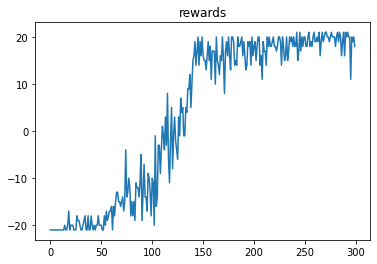

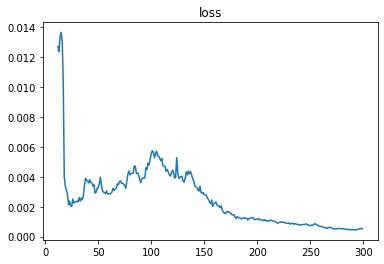

In [7]:
# plot loss and rewards
import matplotlib.pyplot as plt
def plot_(losses, rewards):
    plt.figure()
    plt.title('rewards')
    plt.plot(list(range(len(rewards))), rewards)
    
    plt.figure()
    plt.title('loss')
    plt.plot(list(range(len(losses))),losses)
    plt.show()

plot_(losses, rewards) 